In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import re
import networkx as nx
from operator import itemgetter
import warnings
import matplotlib.cm as mcm
import community
from community import community_louvain as cm
warnings.filterwarnings('ignore')

In [2]:
def get_list_by_keyword(subject, keyword):
    list_by_key = []
    indices = [i for i, x in enumerate(subject.split()) if keyword in x]
    if len(indices) == 0:
        return None
    list_by_key = [None] * len(indices)
    for idx in range(len(indices)):
        list_by_key[idx] = subject.split()[int(indices[idx]+1)].replace("'", "").replace(",", "")
    return list_by_key

In [3]:
#change path and name of files
path = '/Users/marta/Desktop/Master/covid_19/files/'
tweets = pd.read_csv(path+'COVID-19-Tweets/2020-01/tweets.csv', lineterminator='\n')
users = pd.read_csv(path+'COVID-19-Tweets/2020-01/users.csv', lineterminator='\n')

In [4]:
#user_screen_name.lower()
tweets['user_screen_name'] = tweets['user_screen_name'].str.lower()
tweets['rt_user_screen_name'] = tweets['rt_user_screen_name'].str.lower()
tweets['in_reply_to_screen_name'] = tweets['in_reply_to_screen_name'].str.lower()
#tweets = tweets.dropna(subset=['user_id'])
#tweets['user_id'] = [str(i) for i in tweets['user_id']]
users['screen_name'] = users['screen_name'].str.lower()

In [5]:
#check if user_screen_name correspond to univoque user_id
check_ids = tweets.groupby(['user_id','user_screen_name']).size().groupby('user_screen_name').size().reset_index(name='counts')
check_ids[check_ids['counts']>1]

,user_screen_name,counts


In [6]:
retweets = tweets.dropna(subset=['rt_created_at'])
#retweets = tweets.dropna(subset=['rt_user_id'])

In [7]:
replies = tweets.dropna(subset=['in_reply_to_user_id'])

In [8]:
original_tweets = tweets[tweets[['rt_created_at', 'in_reply_to_user_id']].isna().all(1)]
#original_tweets = tweets[tweets[['rt_created_at', 'in_reply_to_status_id']].isna().all(1)]  #it contains more nan values

In [9]:
retweets['created_at'] = pd.to_datetime(retweets['created_at'], format='%a %b %d %H:%M:%S %z %Y')
retweets['rt_created_at'] = pd.to_datetime(retweets['rt_created_at'], format='%a %b %d %H:%M:%S %z %Y')

In [10]:
retweets['seconds_retweet'] = (retweets['created_at']-retweets['rt_created_at']).astype('timedelta64[s]')

In [94]:
len(retweets)

3175177

In [11]:
#filter on retweet where rt_created_at-created_at<=10
seconds = 10
consecutive_retweets = retweets[retweets['seconds_retweet']<=seconds]

In [129]:
retweets_0_seconds = retweets[retweets['seconds_retweet']==0]
len(retweets_0_seconds)

29

In [131]:
len(retweets_0_seconds.user_screen_name.unique())

12

In [132]:
retweets_0_seconds_count = retweets_0_seconds.groupby(['user_screen_name','rt_user_screen_name']).size().reset_index(name='counts')
retweets_0_seconds_count.sort_values(by='counts', ascending=False)

,user_screen_name,rt_user_screen_name,counts
10,raajje_tv,raajjemv,10
5,lykavitosgr,dailyhellascom,4
0,capitalfmkenya,capitalfmsport,2
1,dogberrydrumpf,dogberrydrumpf,2
8,physorg_health,medical_xpress,2
9,physorg_tech,techxplore_com,2
11,stockcharts,stockchartstv,2
2,engagedsmm,kurtlohmann,1
3,eqalerts_m4,eqalerts,1
4,jiveasstrump,jiveasstrump,1


In [17]:
len(consecutive_retweets)

5433

In [18]:
len(consecutive_retweets.user_screen_name.unique())

2118

In [13]:
#count number of retweets of the same user made by another user and maintain only where count>=2
retweets_threshold = 2
consecutive_retweets_count = consecutive_retweets.groupby(['user_screen_name','rt_user_screen_name']).size().reset_index(name='counts')
consecutive_retweets_count = consecutive_retweets_count[consecutive_retweets_count['counts']>=retweets_threshold]
consecutive_retweets_count.sort_values(by='counts', ascending=False)

,user_screen_name,rt_user_screen_name,counts
855,dokscho,business,194
2062,njmike731,cnn,149
2958,viriyabot,reuters,60
1632,kjgheroman,cnn,58
856,dokscho,businessinsider,57
...,...,...,...
1636,kmot_tv,kfyrtv,2
1612,kezi9,bob_schaper,2
1596,kayriss1,cnews,2
1588,kaseycanales_,officialjoelf,2


In [102]:
consecutive_retweets_count[consecutive_retweets_count['user_screen_name']=='dailymail']

,user_screen_name,rt_user_screen_name,counts,conspiracy_score,rt_conspiracy_score
108,dailymail,dailymailuk,2,1.0,1.0
109,dailymail,mailonline,5,1.0,1.0


In [105]:
consecutive_retweets_count[consecutive_retweets_count['rt_user_screen_name']=='dailymail']

,user_screen_name,rt_user_screen_name,counts,conspiracy_score,rt_conspiracy_score
110,dailymailuk,dailymail,3,1.0,1.0
236,mailonline,dailymail,6,1.0,1.0


In [103]:
consecutive_retweets_count[consecutive_retweets_count['user_screen_name']=='dailymailuk']

,user_screen_name,rt_user_screen_name,counts,conspiracy_score,rt_conspiracy_score
110,dailymailuk,dailymail,3,1.0,1.0
111,dailymailuk,mailonline,5,1.0,1.0


In [106]:
consecutive_retweets_count[consecutive_retweets_count['rt_user_screen_name']=='dailymailuk']

,user_screen_name,rt_user_screen_name,counts,conspiracy_score,rt_conspiracy_score
108,dailymail,dailymailuk,2,1.0,1.0
237,mailonline,dailymailuk,7,1.0,1.0


In [104]:
consecutive_retweets_count[consecutive_retweets_count['user_screen_name']=='mailonline']

,user_screen_name,rt_user_screen_name,counts,conspiracy_score,rt_conspiracy_score
236,mailonline,dailymail,6,1.0,1.0
237,mailonline,dailymailuk,7,1.0,1.0


In [107]:
consecutive_retweets_count[consecutive_retweets_count['rt_user_screen_name']=='mailonline']

,user_screen_name,rt_user_screen_name,counts,conspiracy_score,rt_conspiracy_score
109,dailymail,mailonline,5,1.00,1.0
111,dailymailuk,mailonline,5,1.00,1.0
445,viriyabot,mailonline,6,0.02,1.0


In [95]:
len(consecutive_retweets_count.user_screen_name.unique())

304

In [15]:
consecutive_retweets_count['rt_user_screen_name'].value_counts()[:20]

spectatorindex     18
cnn                 9
zerohedge           8
bnodesk             6
cnni                5
firstsquawk         4
ajenglish           4
cnbcnow             4
cp24                3
globalnews          3
fxhedgers           3
cgtnofficial        3
business            3
lookner             3
reuters             3
mailonline          3
quicktake           3
businessinsider     3
skynews             3
dailyhellascom      3
Name: rt_user_screen_name, dtype: int64

In [30]:
consecutive_retweets_graph = nx.from_pandas_edgelist(consecutive_retweets_count,'user_screen_name','rt_user_screen_name', create_using=nx.DiGraph(), edge_attr='counts')
print(nx.info(consecutive_retweets_graph))

Name: 
Type: DiGraph
Number of nodes: 614
Number of edges: 525
Average in degree:   0.8550
Average out degree:   0.8550


In [19]:
isolated_nodes = list(nx.isolates(consecutive_retweets_graph))
print('Isoleted nodes:',len(isolated_nodes))

Isoleted nodes: 0


In [20]:
print('Strongly connected: ',nx.is_strongly_connected(consecutive_retweets_graph))

Strongly connected:  False


In [21]:
print('Number of connected components: ',nx.number_strongly_connected_components(consecutive_retweets_graph))
print('Number of non connected components: ',len(nx.nodes(consecutive_retweets_graph))-nx.number_strongly_connected_components(consecutive_retweets_graph))

Number of connected components:  611
Number of non connected components:  3


In [22]:
# Extract the giant connected component
Gcc = sorted((consecutive_retweets_graph.subgraph(c) for c in nx.strongly_connected_components(consecutive_retweets_graph)), key = len,reverse=True)[0]
print("Number of nodes in the Gcc graph: ")
print(len(Gcc.nodes()))
print("Number of edges in the Gcc graph: ")
print(len(Gcc.edges()))

Number of nodes in the Gcc graph: 
3
Number of edges in the Gcc graph: 
6


In [23]:
Gcc.nodes()

NodeView(('dailymailuk', 'mailonline', 'dailymail'))

In [25]:
consecutive_retweets_graph.remove_edges_from(nx.selfloop_edges(consecutive_retweets_graph))

In [26]:
k_core = nx.k_core(consecutive_retweets_graph, k=None, core_number=None)
print(nx.info(k_core))

Name: 
Type: DiGraph
Number of nodes: 3
Number of edges: 6
Average in degree:   2.0000
Average out degree:   2.0000


In [27]:
k_core.nodes()

NodeView(('dailymailuk', 'mailonline', 'dailymail'))

In [32]:
consecutive_retweets_graph_und = nx.from_pandas_edgelist(consecutive_retweets_count,'user_screen_name','rt_user_screen_name', edge_attr='counts')
print(nx.info(consecutive_retweets_graph_und))

Name: 
Type: Graph
Number of nodes: 614
Number of edges: 521
Average degree:   1.6971


In [33]:
best_part = cm.best_partition(consecutive_retweets_graph_und, random_state=42)

In [34]:
size = float(len(set(best_part.values())))
print("Number of communities: ", size)

Number of communities:  226.0


In [35]:
#check that sum of each community size = number of nodes
communities_size = np.zeros(len(set(best_part.values())))
for v in list(best_part.values()):
    communities_size[v] +=1
print(sum(communities_size))

614.0


In [36]:
for s in range(len(communities_size)):
    print(f'Community {s} has size {int(communities_size[s])}')

Community 0 has size 2
Community 1 has size 3
Community 2 has size 3
Community 3 has size 2
Community 4 has size 2
Community 5 has size 1
Community 6 has size 9
Community 7 has size 1
Community 8 has size 2
Community 9 has size 19
Community 10 has size 18
Community 11 has size 2
Community 12 has size 2
Community 13 has size 108
Community 14 has size 1
Community 15 has size 1
Community 16 has size 1
Community 17 has size 17
Community 18 has size 16
Community 19 has size 5
Community 20 has size 1
Community 21 has size 1
Community 22 has size 1
Community 23 has size 1
Community 24 has size 1
Community 25 has size 2
Community 26 has size 1
Community 27 has size 1
Community 28 has size 1
Community 29 has size 2
Community 30 has size 1
Community 31 has size 3
Community 32 has size 1
Community 33 has size 2
Community 34 has size 1
Community 35 has size 1
Community 36 has size 1
Community 37 has size 28
Community 38 has size 2
Community 39 has size 1
Community 40 has size 3
Community 41 has si

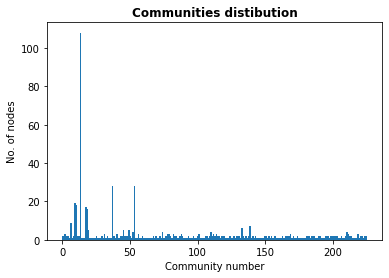

In [37]:
plt.hist(list(best_part.values()), bins=int(size))
plt.xlabel('Community number')
plt.ylabel('No. of nodes')
plt.title('Communities distibution', weight='bold')
#plt.savefig('plots/communities_dist')
plt.show()

In [38]:
print("Louvain Modularity: ",cm.modularity(best_part, consecutive_retweets_graph_und))

Louvain Modularity:  0.8938038100360652


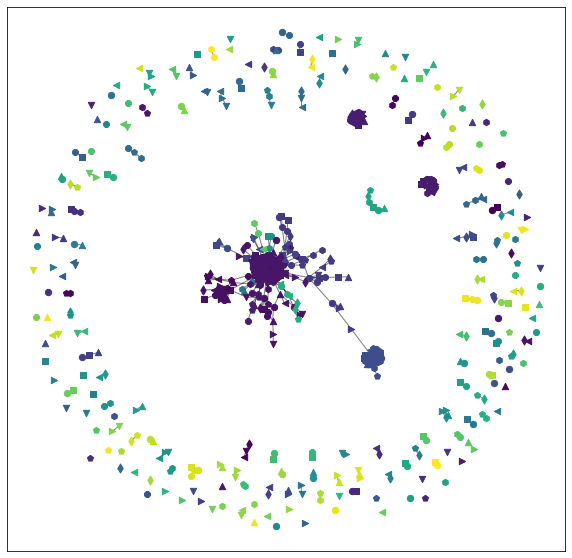

In [46]:
# color the nodes according to their partition
pos = nx.spring_layout(consecutive_retweets_graph_und)

plt.figure(figsize=(10,10)) 
cmap = mcm.get_cmap('viridis', max(best_part.values()) + 1)
shapes = 'so^>v<dph8'
shapes_iter = 0
for node, color in best_part.items():
    nx.draw_networkx_nodes(consecutive_retweets_graph_und, pos, [node], node_size=40,
                           node_color=[cmap.colors[color]],
                           node_shape=shapes[shapes_iter])
    shapes_iter +=1
    if shapes_iter == len(shapes):
        shapes_iter=0
nx.draw_networkx_edges(consecutive_retweets_graph_und, pos, alpha=0.5)
#plt.savefig('plots/communities')
plt.show() #add labels

In [50]:
best_part

{'13abc': 0,
 'mmarshalltv': 0,
 '4cs3420': 1,
 'baucyan1': 1,
 '4tchat': 2,
 'ilovejammu_': 2,
 'superfreeborn': 2,
 '5cs3420': 1,
 '710wor': 3,
 'lenmichaelwor': 3,
 '79wasagreatyear': 37,
 'cnn': 37,
 '966_mbs': 5,
 '_imericsistable': 37,
 '_lydiamj': 6,
 'bnodesk': 6,
 '_trav23': 7,
 'abctricities': 8,
 'wjhl11': 8,
 'abytorresjr': 9,
 'spectatorindex': 9,
 'ace135q': 10,
 'firstsquawk': 10,
 'mdlive4': 10,
 'themarketear': 10,
 'actualidadrt': 11,
 'rtultimahora': 11,
 'airplusnews': 12,
 'airplusnews_en': 12,
 'airrickbrown': 13,
 'nowthisnews': 13,
 'aliboxingfan': 14,
 'alilyinvalley': 15,
 'aliwojo19': 16,
 'all100senators': 17,
 'chriscoons': 17,
 'pattymurray': 17,
 'senalexander': 17,
 'senatorbaldwin': 17,
 'senatorcantwell': 17,
 'senatordurbin': 17,
 'senatorhassan': 17,
 'senatormenendez': 17,
 'senatorshaheen': 17,
 'senduckworth': 17,
 'senfeinstein': 17,
 'sengarypeters': 17,
 'senjeffmerkley': 17,
 'senrickscott': 17,
 'senrobportman': 17,
 'sentomcotton': 17,
 'all

In [52]:
# store the names (the keys of the new dict) as a set (keeps elements unique)
names = set(best_part.values())

# use a list comprehension, iterating through keys and checking the values match each n
communities_dict = {}
for n in names:
    communities_dict[n] = [k for k in best_part.keys() if best_part[k] == n]
communities_dict

{0: ['13abc', 'mmarshalltv'],
 1: ['4cs3420', 'baucyan1', '5cs3420'],
 2: ['4tchat', 'ilovejammu_', 'superfreeborn'],
 3: ['710wor', 'lenmichaelwor'],
 4: ['wsmv', 'wsmvhollyt'],
 5: ['966_mbs'],
 6: ['_lydiamj',
  'bnodesk',
  'elintnews',
  'bnonews',
  'stockboardasset',
  'endgameww3',
  'realandywhat',
  'tokennemo',
  'yymods'],
 7: ['_trav23'],
 8: ['abctricities', 'wjhl11'],
 9: ['abytorresjr',
  'spectatorindex',
  'chuchudepalma',
  'dianeeugenio',
  'eliridder',
  'enribrz',
  'iam_testedok',
  'iamjehova',
  'lllaurenzo',
  'mambamike13',
  'v2019n',
  'plutotcrever',
  'politicsgeek',
  'saulgattuso',
  'pmbreakingnews',
  'strawhatlife',
  'the_nifemi',
  'vittoriog82',
  'yung_scoopgod'],
 10: ['ace135q',
  'firstsquawk',
  'mdlive4',
  'themarketear',
  'alxmnt87',
  'zerohedge',
  'capitalarias',
  'c_barraud',
  'livesquawk',
  'deegrose',
  'dude_gman',
  'fxhedgers',
  'israel_massa',
  'chinesehedge',
  'makemoneycfa',
  'naminore88',
  'qtrresearch',
  'tradesandr

In [62]:
users_cred = pd.read_csv('/Users/marta/Desktop/Master/covid_19/files/decompressed/users_cred_2020-01.csv')
users_cred['user_screen_name'] = users_cred['user_screen_name'].str.lower()

In [63]:
users_cred.head()

,user_screen_name,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score
0,axelrod_ej,15,0,15,0,0,1.0
1,breitbartlondon,10,0,10,0,0,1.0
2,steelerslilddjg,10,0,10,0,0,1.0
3,ritchiejodi,35,0,17,18,0,1.0
4,1962cg,18,0,17,1,0,1.0


In [98]:
users_cred.columns

Index(['rt_user_screen_name', 'number_of_urls', 'HIGH', 'LOW', 'UNKW',
       'SOCIAL', 'conspiracy_score'],
      dtype='object')

In [128]:
users_cred[users_cred['rt_user_screen_name']=='mailonline']

,rt_user_screen_name,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score
23,mailonline,133,0,131,2,0,1.0


In [64]:
consecutive_retweets_count = consecutive_retweets_count.merge(users_cred[['user_screen_name','conspiracy_score']], how='left',on='user_screen_name')

In [67]:
users_cred = users_cred.rename(columns = {'user_screen_name': 'rt_user_screen_name'})

In [69]:
consecutive_retweets_count = consecutive_retweets_count.merge(users_cred[['rt_user_screen_name','conspiracy_score']], how='left',on='rt_user_screen_name')

In [72]:
consecutive_retweets_count = consecutive_retweets_count.rename(columns = {'conspiracy_score_x': 'conspiracy_score', 'conspiracy_score_y': 'rt_conspiracy_score'})

In [73]:
consecutive_retweets_count

,user_screen_name,rt_user_screen_name,counts,conspiracy_score,rt_conspiracy_score
0,13abc,mmarshalltv,2,NaN,NaN
1,4cs3420,baucyan1,8,NaN,NaN
2,4tchat,ilovejammu_,2,0.07,NaN
3,4tchat,superfreeborn,2,0.07,NaN
4,5cs3420,baucyan1,8,NaN,NaN
...,...,...,...,...,...
520,yogeshyoyo007,cnni,9,0.06,NaN
521,yogeshyoyo007,dailycaller,2,0.06,0.0
522,yung_scoopgod,spectatorindex,4,NaN,NaN
523,yymods,bnodesk,4,NaN,0.0


In [84]:
consecutive_retweets_count_conspiracy = consecutive_retweets_count[(consecutive_retweets_count['conspiracy_score']==1) | (consecutive_retweets_count['rt_conspiracy_score']==1)]

In [85]:
len(consecutive_retweets_count_conspiracy)

16

In [92]:

best_part_cosp = {k: v for k, v in best_part.items() if (k in consecutive_retweets_count_conspiracy.user_screen_name.unique()) | (k in consecutive_retweets_count_conspiracy.rt_user_screen_name.unique())}
##
                                                         

In [93]:
best_part_cosp

{'alxmnt87': 10,
 'zerohedge': 10,
 'capitalarias': 10,
 'dailymail': 56,
 'dailymailuk': 56,
 'mailonline': 56,
 'deegrose': 10,
 'dude_gman': 10,
 'makemoneycfa': 10,
 'qtrresearch': 10,
 'tradesandraids': 10,
 'viriyabot': 13,
 'caixin': 13}

In [87]:
consecutive_retweets_count_conspiracy

,user_screen_name,rt_user_screen_name,counts,conspiracy_score,rt_conspiracy_score
55,alxmnt87,zerohedge,2,NaN,1.0
85,capitalarias,zerohedge,4,NaN,1.0
108,dailymail,dailymailuk,2,1.00,1.0
109,dailymail,mailonline,5,1.00,1.0
110,dailymailuk,dailymail,3,1.00,1.0
111,dailymailuk,mailonline,5,1.00,1.0
118,deegrose,zerohedge,5,NaN,1.0
135,dude_gman,zerohedge,6,NaN,1.0
236,mailonline,dailymail,6,1.00,1.0
237,mailonline,dailymailuk,7,1.00,1.0


In [119]:
consecutive_retweets_count_conspiracy_graph = nx.from_pandas_edgelist(consecutive_retweets_count_conspiracy,'user_screen_name','rt_user_screen_name', create_using=nx.DiGraph(), edge_attr='counts')
print(nx.info(consecutive_retweets_count_conspiracy_graph))

Name: 
Type: DiGraph
Number of nodes: 13
Number of edges: 16
Average in degree:   1.2308
Average out degree:   1.2308


In [120]:
consecutive_retweets_count_conspiracy_graph.nodes()

NodeView(('alxmnt87', 'zerohedge', 'capitalarias', 'dailymail', 'dailymailuk', 'mailonline', 'deegrose', 'dude_gman', 'makemoneycfa', 'qtrresearch', 'tradesandraids', 'viriyabot', 'caixin'))

In [121]:
consecutive_retweets_count_conspiracy_graph.nodes['alxmnt87']

{}

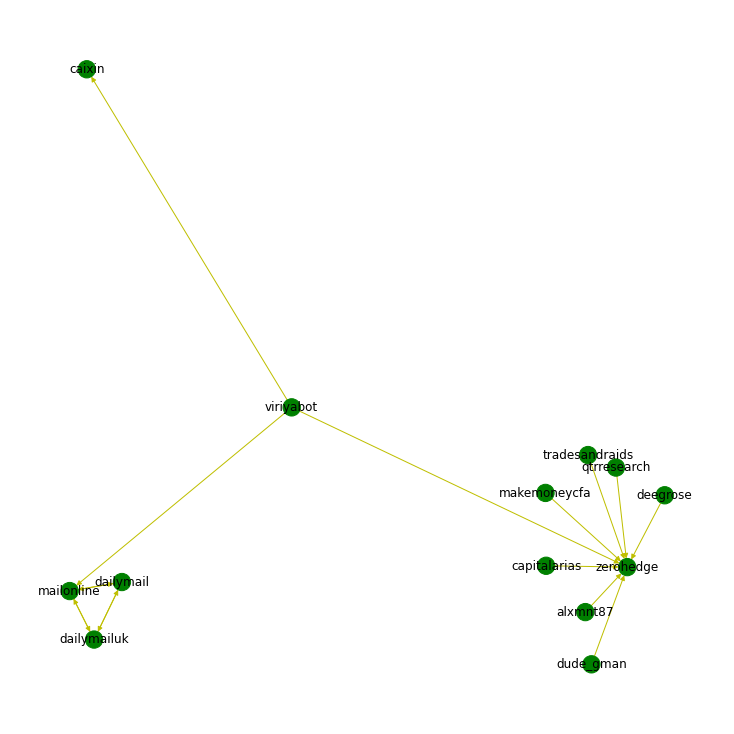

In [125]:
labels = {}    
color_map = ['g']*len(consecutive_retweets_count_conspiracy_graph.nodes())
idx = 0
for node in consecutive_retweets_count_conspiracy_graph.nodes():
    labels[node] = node
    idx+=1
plt.figure(figsize=(10,10)) 
consecutive_retweets_count_conspiracy_graph_relabel = nx.relabel_nodes(consecutive_retweets_count_conspiracy_graph, labels)


nx.draw( consecutive_retweets_count_conspiracy_graph_relabel, with_labels=True, node_color=color_map, edge_color='y')
#plt.savefig('plots/k_core')
plt.show()

In [88]:
for i in communities_dict.keys():
    print('Community ',i)
    print(consecutive_retweets_count[consecutive_retweets_count['user_screen_name'].isin(communities_dict[i])])
    print('\n')

Community  0
  user_screen_name rt_user_screen_name  counts  conspiracy_score  \
0            13abc         mmarshalltv       2               NaN   

   rt_conspiracy_score  
0                  NaN  


Community  1
  user_screen_name rt_user_screen_name  counts  conspiracy_score  \
1          4cs3420            baucyan1       8               NaN   
4          5cs3420            baucyan1       8               NaN   

   rt_conspiracy_score  
1                  NaN  
4                  NaN  


Community  2
  user_screen_name rt_user_screen_name  counts  conspiracy_score  \
2           4tchat         ilovejammu_       2              0.07   
3           4tchat       superfreeborn       2              0.07   

   rt_conspiracy_score  
2                  NaN  
3                  NaN  


Community  3
  user_screen_name rt_user_screen_name  counts  conspiracy_score  \
5           710wor       lenmichaelwor       3               NaN   

   rt_conspiracy_score  
5                  NaN  


Commun

159                  NaN  


Community  83
    user_screen_name rt_user_screen_name  counts  conspiracy_score  \
160       fox23maine                wgme       2               NaN   

     rt_conspiracy_score  
160                  NaN  


Community  84
    user_screen_name rt_user_screen_name  counts  conspiracy_score  \
161         france24         france24_en       2               NaN   

     rt_conspiracy_score  
161                  NaN  


Community  85
    user_screen_name rt_user_screen_name  counts  conspiracy_score  \
162       franksowa1          franksowa1      21              0.21   

     rt_conspiracy_score  
162                 0.21  


Community  86
    user_screen_name rt_user_screen_name  counts  conspiracy_score  \
163      freitagwolf         freitagwolf       2               NaN   

     rt_conspiracy_score  
163                  NaN  


Community  87
    user_screen_name rt_user_screen_name  counts  conspiracy_score  \
165             gdla               foxla   

319                  NaN  


Community  175
    user_screen_name rt_user_screen_name  counts  conspiracy_score  \
321     raftery_paul        raftery_paul       2               NaN   

     rt_conspiracy_score  
321                  NaN  


Community  176
    user_screen_name rt_user_screen_name  counts  conspiracy_score  \
322   ragnar29574929      ragnar29574929       2               NaN   

     rt_conspiracy_score  
322                  NaN  


Community  177
    user_screen_name rt_user_screen_name  counts  conspiracy_score  \
323  ratchet_clank10     ratchet_clank10      27               NaN   

     rt_conspiracy_score  
323                  NaN  


Community  178
    user_screen_name rt_user_screen_name  counts  conspiracy_score  \
325   redhoodwould60      redhoodwould60       6               NaN   

     rt_conspiracy_score  
325                  NaN  


Community  179
    user_screen_name rt_user_screen_name  counts  conspiracy_score  \
326    renegadestyle       renegadesty